##### Copyright 2019 The TensorFlow Authors.

In [323]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial is an introduction to time series forecasting using TensorFlow. It builds a few different styles of models including Convolutional and Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections: 

* Forecast for a single time step:
  * A single feature.
  * All features.
* Forecast multiple steps:
  * Single-shot: Make the predictions all at once.
  * Autoregressive: Make one prediction at a time and feed the output back to the model.

## Setup

In [324]:
%matplotlib inline

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from pathlib import Path

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
# plt.rcParams['figure.dpi'] = 300

np.random.seed(42)
tf.random.set_seed(42)

In [325]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [326]:
!nvidia-smi

Sun May 15 22:47:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.68.01    Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P2    51W / 200W |   1915MiB /  4096MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [327]:
lstm_units = 63

## The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [328]:
# zip_path = tf.keras.utils.get_file(
#     origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#     fname='jena_climate_2009_2016.csv.zip',
#     extract=True)
# csv_path, _ = os.path.splitext(zip_path)

# csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL.csv"
# csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL_WITH_BENZINGA_SA.csv"
# csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL_WITH_TWITTER_SA.csv"

# csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL_WITH_BENZINGA_FINBERT_SA.csv"
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL_WITH_TWINT_FINBERT_SA.csv"

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [329]:
df = pd.read_csv(csv_path)
df.sort_values(by=["date"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
# Slice [start:stop:step], starting from index 5 take every 6th record.
# df = df[5::6]

date_time = pd.to_datetime(df.pop('date'))
# title = df.pop('tweet')

df = df[["2. high", "3. low", "5. adjusted close", "positive"]] 

# df = df[["5. adjusted close"]] 

# test: 0.0076 (train: 0.0045)
# df = df[["2. high", "3. low", "5. adjusted close", "positive"]] 

# test:  0.0107 (train 0.0071)
# df = df[["2. high", "3. low", "5. adjusted close", "negative", "nuetral", "positive"]] 
# test 0.0117 (train 0.0077)
# df = df[["2. high", "3. low", "5. adjusted close"]]  
# df = df[["2. high", "3. low", "5. adjusted close", "negative", "nuetral", "positive"]]  
# df = df[["1. open", "2. high", "3. low", "5. adjusted close", "6. volume", "negative", "nuetral", "positive"]]

###  BEST MODEL ###  
# test: 0.0076 (train: 0.0045)
# df = df[["2. high", "3. low", "5. adjusted close", "positive"]]  TWINT
# test:  0.0107 (train 0.0071)
# df = df[["2. high", "3. low", "5. adjusted close", "negative", "nuetral", "positive"]] 
###  2nd BEST MODEL ###  
# test 0.0117 (train 0.0077)
# df = df[["2. high", "3. low", "5. adjusted close"]]  

# df = df[["5. adjusted close", "compound_financial_news", "compound_financial_tweets", "nretweets"]]
# df = df[["1. open", "2. high", "3. low", "5. adjusted close", "6. volume"]]
# df = df[["1. open", "2. high", "3. low", "5. adjusted close", "6. volume", "compound_financial_news"]]
# df = df[["1. open", "2. high", "3. low", "5. adjusted close", "6. volume", "compound_financial_news", "compound_financial_tweets", "nlikes"]]
# df = df[["1. open", "2. high", "3. low", "5. adjusted close", "6. volume", "compound_financial_news", "nretweets"]]


Let's take a glance at the data. Here are the first few rows:

In [330]:
df.head()

,2. high,3. low,5. adjusted close,positive
0,214.50,212.38,6.543876,0.999984
1,215.59,213.25,6.555190,0.500169
2,215.23,210.75,6.450921,0.914247
3,212.00,209.05,6.438996,0.542766
4,212.00,209.06,6.481804,0.989783


In [331]:
df.shape

(3064, 4)

Here is the evolution of a few features over time:

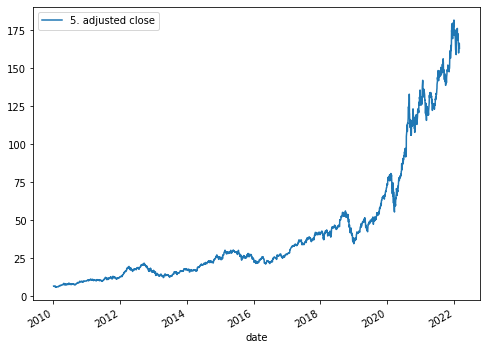

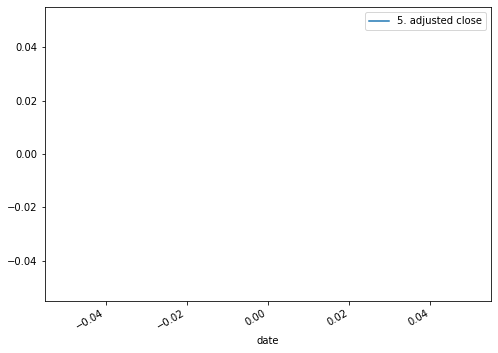

In [332]:
# plot_cols = ['1. open', '2. high', '3. low', '4. close', '5. adjusted close', '6. volume']
plot_cols = ['5. adjusted close']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][5500:]
plot_features.index = date_time[5500:]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [333]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
2. high,3064.0,262.829696,161.044982,9.070000e+01,129.535000,194.330000,369.210000,705.070000
3. low,3064.0,257.667717,157.946296,8.947000e+01,127.102500,190.875000,358.682500,699.570000
5. adjusted close,3064.0,42.736360,41.154337,5.872396e+00,16.285903,26.270965,48.589739,181.778019
positive,3064.0,0.752544,0.169262,8.860724e-09,0.660843,0.765823,0.867453,0.999999


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [334]:
# wv = df['wv (m/s)']
# bad_wv = wv == -9999.0
# wv[bad_wv] = 0.0

# max_wv = df['max. wv (m/s)']
# bad_max_wv = max_wv == -9999.0
# max_wv[bad_max_wv] = 0.0

# # The above inplace edits are reflected in the DataFrame.
# df['wv (m/s)'].min()

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

In [335]:
# plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
# plt.colorbar()
# plt.xlabel('Wind Direction [deg]')
# plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [336]:
# wv = df.pop('wv (m/s)')
# max_wv = df.pop('max. wv (m/s)')

# # Convert to radians.
# wd_rad = df.pop('wd (deg)')*np.pi / 180

# # Calculate the wind x and y components.
# df['Wx'] = wv*np.cos(wd_rad)
# df['Wy'] = wv*np.sin(wd_rad)

# # Calculate the max wind x and y components.
# df['max Wx'] = max_wv*np.cos(wd_rad)
# df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

In [337]:
# plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
# plt.colorbar()
# plt.xlabel('Wind X [m/s]')
# plt.ylabel('Wind Y [m/s]')
# ax = plt.gca()
# ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [338]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [339]:
# day = 24*60*60
# year = (365.2425)*day

# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
# df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
# df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [340]:
# plt.plot(np.array(df['Day sin'])[:25])
# plt.plot(np.array(df['Day cos'])[:25])
# plt.xlabel('Time [h]')
# plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


In [341]:
# fft = tf.signal.rfft(df['T (degC)'])
# f_per_dataset = np.arange(0, len(fft))

# n_samples_h = len(df['T (degC)'])
# hours_per_year = 24*365.2524
# years_per_dataset = n_samples_h/(hours_per_year)

# f_per_year = f_per_dataset/years_per_dataset
# plt.step(f_per_year, np.abs(fft))
# plt.xscale('log')
# plt.ylim(0, 400000)
# plt.xlim([0.1, max(plt.xlim())])
# plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
# _ = plt.xlabel('Frequency (log scale)')

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [342]:
column_indices = {name: i for i, name in enumerate(df.columns)}

split_time = int(len(df) * .9)

train_df = df[:split_time]
test_df = df[split_time:]


num_features = df.shape[1]

In [343]:
test_df

,2. high,3. low,5. adjusted close,positive
2757,127.90,124.130,126.934789,0.698398
2758,128.37,126.560,126.865306,0.658722
2759,129.58,128.045,127.748728,0.864368
2760,129.10,126.120,125.718843,0.888847
2761,128.31,123.449,127.282202,0.904564
...,...,...,...,...
3059,165.42,162.430,165.120000,0.896855
3060,166.60,161.970,163.200000,0.665971
3061,167.36,162.950,166.560000,0.849497
3062,168.91,165.550,166.230000,0.860109


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [344]:
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# # val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(train_df.values)

train_df_scaled = pd.DataFrame(scaled_features, index=train_df.index, columns=train_df.columns)

scaled_features = scaler.transform(test_df.values)

test_df_scaled = pd.DataFrame(scaled_features, index=test_df.index, columns=test_df.columns)

In [345]:
test_df_scaled

,2. high,3. low,5. adjusted close,positive
2757,0.060550,0.056810,0.952601,0.698399
2758,0.061315,0.060793,0.952054,0.658723
2759,0.063284,0.063227,0.959005,0.864369
2760,0.062503,0.060072,0.943033,0.888848
2761,0.061217,0.055694,0.955334,0.904565
...,...,...,...,...
3059,0.121621,0.119587,1.253068,0.896856
3060,0.123541,0.118833,1.237960,0.665971
3061,0.124778,0.120439,1.264399,0.849498
3062,0.127301,0.124701,1.261802,0.860110


Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

In [346]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [347]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               # train_df=train_df, val_df=val_df, test_df=test_df,
               train_df=train_df_scaled, test_df=test_df_scaled,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    # self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [348]:
w1 = WindowGenerator(input_width=lstm_units, label_width=1, shift=5,
                     label_columns=['5. adjusted close'])
w1

Total window size: 68
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Label indices: [67]
Label column name(s): ['5. adjusted close']

In [349]:
w2 = WindowGenerator(input_width=lstm_units, label_width=1, shift=1,
                     label_columns=['5. adjusted close'])
w2

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Label indices: [63]
Label column name(s): ['5. adjusted close']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [350]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [351]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 64, 4)
Inputs shape: (3, 63, 4)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [352]:
w2.example = example_inputs, example_labels

In [353]:
def plot(self, model=None, plot_col='5. adjusted close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

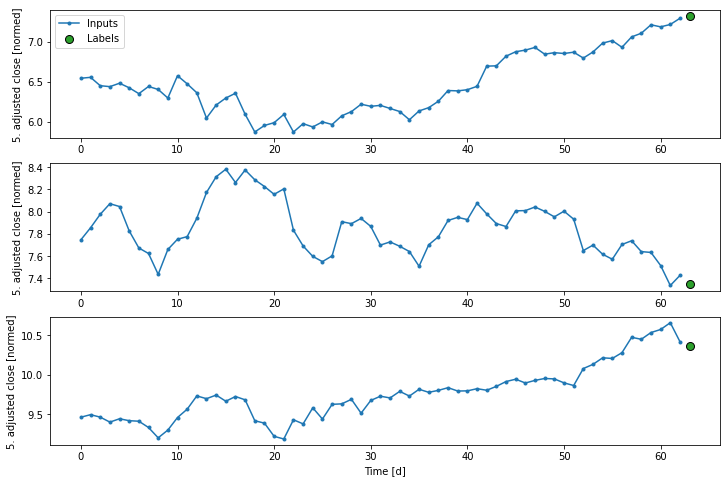

In [354]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

In [355]:
# w2.plot(plot_col='6. volume')

### 4. Create `tf.data.Dataset(s)`

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [356]:
shuffle_ds = True

In [357]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=shuffle_ds,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [358]:
@property
def train(self):
  return self.make_dataset(self.train_df)

# @property
# def val(self):
#   return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
# WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [359]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 63, 4), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [360]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 63, 4)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one hour) into the future based only on the current conditions.

So, start by building models to predict the `T (degC)` value one hour into the future.

![Predict the next time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [361]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['5. adjusted close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['5. adjusted close']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [362]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 4)
Labels shape (batch, time, features): (32, 1, 1)


In [363]:
tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [364]:
results_path = Path('results', 'lstm')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [365]:
# MAX_EPOCHS = 500
MAX_EPOCHS = 100
# patience=50
patience=10

results_path = Path('results', 'lstm')
if not results_path.exists():
    results_path.mkdir(parents=True)


lstm_path = (results_path / 'lstm.h5').as_posix()
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                     # learning_rate=lr_schedule,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',  
                                                    restore_best_weights=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.test,
                      shuffle = True,
                      callbacks=[early_stopping, checkpointer])
  return history

In [366]:
# window.train

### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.

![Send the input to the output](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/baseline.png?raw=1)

In [367]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

Instantiate and evaluate this model:

In [368]:
baseline = Baseline(label_index=column_indices['5. adjusted close'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

test_performance = {}
performance = {}
test_performance['Baseline'] = baseline.evaluate(single_step_window.test)
performance['Baseline'] = baseline.evaluate(single_step_window.train, verbose=0)

10/10 [==============================] - 0s 5ms/step - loss: 3.4095e-04 - mean_absolute_error: 0.0140


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows 24 hours of consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [369]:
wide_window = WindowGenerator(
    input_width=lstm_units, label_width=lstm_units, shift=1,
    label_columns=['5. adjusted close'])

wide_window

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): ['5. adjusted close']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

In [370]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 63, 4)
Output shape: (32, 63, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one hour:

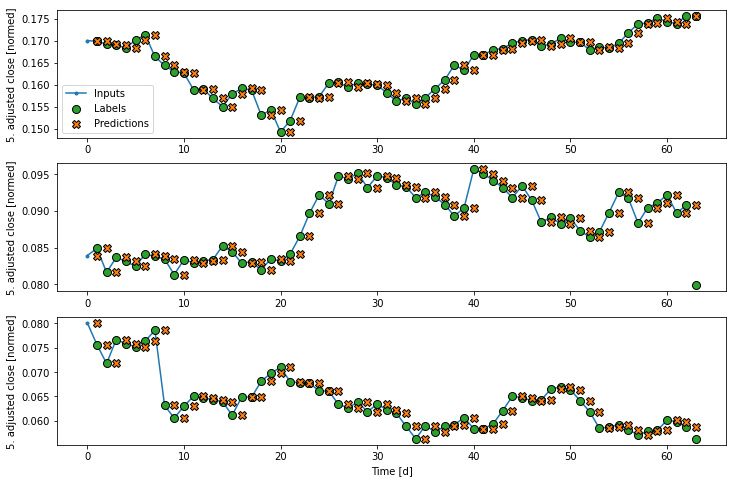

In [371]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue `Inputs` line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [372]:
# best parameters
# tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
# tf.keras.layers.Dropout(0.20),

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    # tf.keras.layers.Dropout(0.20),
    # tf.keras.layers.LSTM(units=lstm_units, input_shape=(63, 1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    # tf.keras.layers.LSTM(units=lstm_units, return_sequences=False),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
     #tf.keras.layers.LSTM(units=lstm_units, return_sequences=True),
    # tf.keras.layers.LSTM(units=lstm_units, return_sequences=True),
    # tf.keras.layers.Dropout(0.20),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, name='Output')
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [373]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 63, 4)
Output shape: (32, 63, 1)


In [374]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (32, 63, 126)            34272     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (32, 63, 126)             0         
                                                                 
 Output (Dense)              (32, 63, 1)               127       
                                                                 
Total params: 34,399
Trainable params: 34,399
Non-trainable params: 0
_________________________________________________________________


In [375]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
test_performance['LSTM'] = lstm_model.evaluate(wide_window.test)
performance['LSTM'] = lstm_model.evaluate(wide_window.train, verbose=0)

8/8 [==============================] - 0s 13ms/step - loss: 1.9656e-04 - mean_absolute_error: 0.0108


In [438]:
for i in wide_window.train:
    print(i[0][0][1])

tf.Tensor([0.20328142 0.20288478 0.00537269 0.50016934], shape=(4,), dtype=float32)
tf.Tensor([0.18197504 0.17983937 0.00201289 0.93061334], shape=(4,), dtype=float32)
tf.Tensor([0.2455198  0.24351746 0.01152493 0.99978155], shape=(4,), dtype=float32)
tf.Tensor([0.2607549  0.25699067 0.01316344 0.6684002 ], shape=(4,), dtype=float32)
tf.Tensor([0.27540407 0.27157843 0.01625761 0.9999661 ], shape=(4,), dtype=float32)
tf.Tensor([0.24789622 0.2445173  0.01152011 0.7470789 ], shape=(4,), dtype=float32)
tf.Tensor([0.33172193 0.32868382 0.02454641 0.9724373 ], shape=(4,), dtype=float32)
tf.Tensor([0.35979947 0.3558269  0.02807366 0.5200413 ], shape=(4,), dtype=float32)
tf.Tensor([0.41103896 0.405999   0.03618803 0.90589523], shape=(4,), dtype=float32)
tf.Tensor([0.4195029  0.41850516 0.03756068 0.80613375], shape=(4,), dtype=float32)
tf.Tensor([0.39557597 0.39457467 0.03376876 0.7448291 ], shape=(4,), dtype=float32)
tf.Tensor([0.40192392 0.40131125 0.03497418 0.79954433], shape=(4,), dtype=f

In [377]:
test_performance['LSTM']

[0.00019656460790429264, 0.010781646706163883]

In [378]:
wide_window.example[0].shape

TensorShape([32, 63, 4])

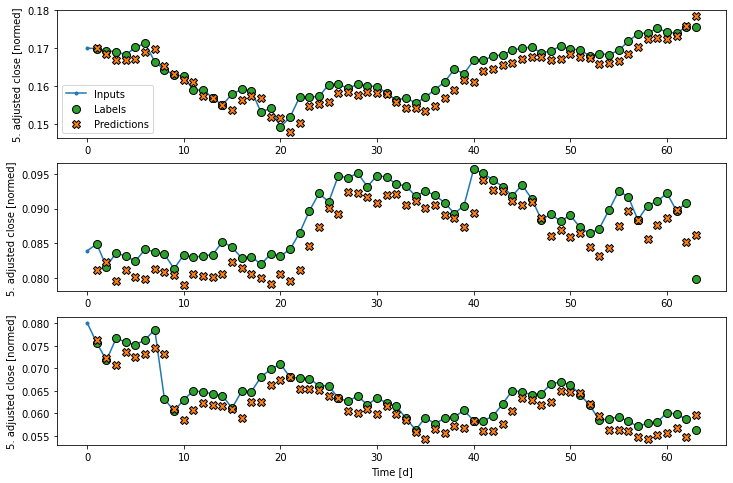

In [379]:
wide_window.plot(lstm_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

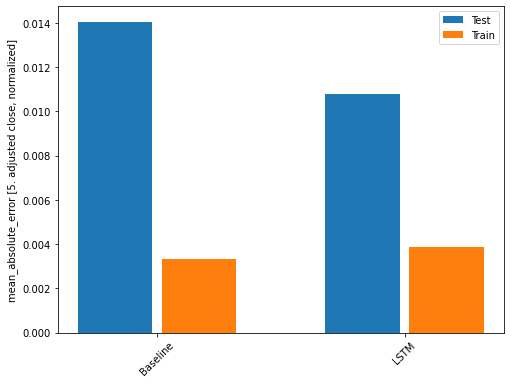

In [380]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
test_mae = [v[metric_index] for v in test_performance.values()]
train_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [5. adjusted close, normalized]')
plt.bar(x - 0.17, test_mae, width, label='Test')
plt.bar(x + 0.17, train_mae, width, label='Train')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [381]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0033
LSTM        : 0.0039


In [382]:
shuffle_ds = False

In [383]:
wide_window = WindowGenerator(
    input_width=lstm_units, label_width=lstm_units, shift=1,
    label_columns=['5. adjusted close'])

wide_window

Total window size: 64
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Label column name(s): ['5. adjusted close']

In [429]:
len(train_df_scaled)

2757

In [428]:
len(test_df_scaled)

307

In [386]:
train_predict_scaled = lstm_model.predict(wide_window.train).squeeze()
test_predict_scaled = lstm_model.predict(wide_window.test).squeeze()

In [387]:
len(train_predict_scaled)

2694

In [388]:
len(test_predict_scaled)

244

In [392]:
_train_predict_scaled = np.zeros([2694,], dtype='float32')
_test_predict_scaled = np.zeros([244,], dtype='float32')
# _test_predict_scaled = np.zeros([5,], dtype='float32')

In [393]:
for i, x in enumerate(train_predict_scaled):
    _train_predict_scaled[i] = x[-1]

In [394]:
for i, x in enumerate(test_predict_scaled):
    _test_predict_scaled[i] = x[-1]

In [395]:
from sklearn.metrics import mean_absolute_error

## Mean Absolute Error (Scaled)

In [426]:
# mean_absolute_error: 0.0106
train_mae = mean_absolute_error(train_df_scaled[63:]['5. adjusted close'].to_numpy(), _train_predict_scaled)
test_mae = mean_absolute_error(test_df_scaled[63:]['5. adjusted close'].to_numpy(), _test_predict_scaled)
f'Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}'

'Train MAE: 0.0080 | Test MAE: 0.0178'

In [406]:
split_time

2757

In [407]:
y_true_train = df[63:split_time]['5. adjusted close']

In [408]:
y_true_test = df[split_time+63:]['5. adjusted close']

In [409]:
y_train_index = date_time[63:split_time]

In [410]:
y_test_index = date_time[split_time+63:]

In [411]:
y_true_test

2820    119.818452
2821    119.281640
2822    122.661568
2823    121.816586
2824    119.381049
           ...    
3059    165.120000
3060    163.200000
3061    166.560000
3062    166.230000
3063    163.170000
Name: 5. adjusted close, Length: 244, dtype: float64

In [412]:
train_df.index = date_time[:split_time]
test_df.index = date_time[split_time:]

In [413]:
test_df

,2. high,3. low,5. adjusted close,positive
date,,,,
2020-12-15,127.90,124.130,126.934789,0.698398
2020-12-16,128.37,126.560,126.865306,0.658722
2020-12-17,129.58,128.045,127.748728,0.864368
2020-12-18,129.10,126.120,125.718843,0.888847
2020-12-21,128.31,123.449,127.282202,0.904564
...,...,...,...,...
2022-02-28,165.42,162.430,165.120000,0.896855
2022-03-01,166.60,161.970,163.200000,0.665971
2022-03-02,167.36,162.950,166.560000,0.849497


In [414]:
train_df_x = train_df[['5. adjusted close']]
test_df_x = test_df[['5. adjusted close']]

In [415]:
test_df_x

,5. adjusted close
date,
2020-12-15,126.934789
2020-12-16,126.865306
2020-12-17,127.748728
2020-12-18,125.718843
2020-12-21,127.282202
...,...
2022-02-28,165.120000
2022-03-01,163.200000
2022-03-02,166.560000


In [416]:
# from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_features = scaler.fit_transform(train_df_x.values)

train_df = pd.DataFrame(scaled_features, index=train_df_x.index, columns=train_df_x.columns)

scaled_features = scaler.transform(test_df_x.values)

test_df = pd.DataFrame(scaled_features, index=test_df_x.index, columns=test_df_x.columns)

In [417]:
test_df_x

,5. adjusted close
date,
2020-12-15,126.934789
2020-12-16,126.865306
2020-12-17,127.748728
2020-12-18,125.718843
2020-12-21,127.282202
...,...
2022-02-28,165.120000
2022-03-01,163.200000
2022-03-02,166.560000


In [ ]:
# train_df.rename(columns={0: "5. adjusted close"}, inplace=True)
# test_df.rename(columns={0: "5. adjusted close"}, inplace=True)

In [418]:
scaler.inverse_transform(_test_predict_scaled.reshape(-1, 1))

array([[122.10584 ],
       [117.99377 ],
       [117.57287 ],
       [120.69118 ],
       [119.12847 ],
       [117.585144],
       [118.440475],
       [118.58073 ],
       [118.67764 ],
       [117.70725 ],
       [119.166954],
       [120.54739 ],
       [123.59745 ],
       [123.02671 ],
       [124.96183 ],
       [127.72994 ],
       [130.61108 ],
       [128.8206  ],
       [131.9233  ],
       [129.62535 ],
       [132.11269 ],
       [132.25215 ],
       [131.94215 ],
       [130.29065 ],
       [131.09943 ],
       [129.585   ],
       [132.33159 ],
       [132.91063 ],
       [132.0437  ],
       [129.80241 ],
       [130.07573 ],
       [128.42085 ],
       [129.53607 ],
       [125.63499 ],
       [125.357925],
       [127.31872 ],
       [128.13503 ],
       [124.29209 ],
       [123.28542 ],
       [120.33608 ],
       [122.32235 ],
       [125.57614 ],
       [123.951096],
       [122.48227 ],
       [122.61767 ],
       [124.835106],
       [122.96817 ],
       [124.9

In [419]:
train_predict_rescaled = pd.Series(scaler.inverse_transform(_train_predict_scaled.reshape(-1, 1)).squeeze(), index=y_train_index)
test_predict_rescaled = pd.Series(scaler.inverse_transform(_test_predict_scaled.reshape(-1, 1)).squeeze(), index=y_test_index)
# train_predict_rescaled = pd.Series(scaler.inverse_transform(_train_predict_scaled), index=y_train_index)
# test_predict_rescaled = pd.Series(scaler.inverse_transform(_test_predict_scaled), index=y_test_index)

In [420]:
test_predict_rescaled[-1]

165.90375

In [ ]:
df

,2. high,3. low,5. adjusted close,positive
0,214.50,212.38,6.543876,0.999984
1,215.59,213.25,6.555190,0.500169
2,215.23,210.75,6.450921,0.914247
3,212.00,209.05,6.438996,0.542766
4,212.00,209.06,6.481804,0.989783
...,...,...,...,...
3059,165.42,162.43,165.120000,0.896855
3060,166.60,161.97,163.200000,0.665971
3061,167.36,162.95,166.560000,0.849497
3062,168.91,165.55,166.230000,0.860109


## Mean Absolute Error (Rescaled)

In [427]:
train_mse = mean_absolute_error(train_predict_rescaled, y_true_train)
test_mse = mean_absolute_error(test_predict_rescaled, y_true_test)
f'Train MAE: {train_mse:.4f} | Test MAE: {test_mse:.4f}'

'Train MAE: 1.0134 | Test MAE: 2.2597'

In [422]:
test_predict_rescaled[-5:]

date
2022-02-28    163.683060
2022-03-01    164.527496
2022-03-02    162.005661
2022-03-03    165.674118
2022-03-04    165.903748
dtype: float32

In [423]:
y_true_test[-5:]

3059    165.12
3060    163.20
3061    166.56
3062    166.23
3063    163.17
Name: 5. adjusted close, dtype: float64